In [90]:
import torch
import torchio as tio
from typing import Tuple


"""Module for custom transforms."""
class RandomCrop:
    """Random cropping on subject."""

    def __init__(self, roi_size: Tuple):
        """Init.

        Args:
            roi_size: cropping size.
        """
        self.sampler = tio.data.LabelSampler(patch_size=roi_size, label_name="label")

    def __call__(self, subject: tio.Subject) -> tio.Subject:
        """Use patch sampler to crop.

        Args:
            subject: subject having image and label.

        Returns:
            cropped subject
        """
        for patch in self.sampler(subject=subject, num_patches=1):
            return patch


class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, list_IDs):
        'Initialization'
        # self.labels = labels
        self.list_IDs = list_IDs
        self.img_size = 64

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    @staticmethod
    def get_augmentation_transform():
        augment = tio.Compose([
            tio.RandomAffine(),
            tio.RandomFlip(p=0.5),
            tio.RandomGamma(p=0.5),
            tio.RandomNoise(p=0.5),
            tio.RandomMotion(p=0.1),
            tio.RandomBiasField(p=0.25)
        ])
        return augment

    @staticmethod
    def get_new_transforms(transformed):

        new_augment = []
        for transformation in transformed.get_applied_transforms():
            if isinstance(transformation, tio.Noise):
                transformation.std['image_fluence'] = transformation.std['image_ct']
                transformation.std['image_body'] = transformation.std['image_ct']
                transformation.std['label'] = transformation.std['image_ct']
                transformation.seed['image_fluence'] = transformation.seed['image_ct']
                transformation.seed['image_body'] = transformation.seed['image_ct']
                transformation.seed['label'] = transformation.seed['image_ct']
            elif isinstance(transformation, tio.Gamma):
                transformation.gamma['image_fluence'] = transformation.gamma['image_ct']
                transformation.gamma['image_body'] = transformation.gamma['image_ct']
                transformation.gamma['label'] = transformation.gamma['image_ct']
            elif isinstance(transformation, tio.Motion):
                transformation.degrees['image_fluence'] = transformation.degrees['image_ct']
                transformation.degrees['image_body'] = transformation.degrees['image_ct']
                transformation.degrees['label'] = transformation.degrees['image_ct']
                transformation.translation['image_fluence'] = transformation.translation['image_ct']
                transformation.translation['image_body'] = transformation.translation['image_ct']
                transformation.translation['label'] = transformation.translation['image_ct']
                transformation.times['image_fluence'] = transformation.times['image_ct']
                transformation.times['image_body'] = transformation.times['image_ct']
                transformation.times['label'] = transformation.times['image_ct']
                transformation.image_interpolation['image_fluence'] = transformation.image_interpolation['image_ct']
                transformation.image_interpolation['image_body'] = transformation.image_interpolation['image_ct']
                transformation.image_interpolation['label'] = transformation.image_interpolation['image_ct']
            elif isinstance(transformation, tio.BiasField):
                transformation.coefficients['image_fluence'] = transformation.coefficients['image_ct']
                transformation.coefficients['image_body'] = transformation.coefficients['image_ct']
                transformation.coefficients['label'] = transformation.coefficients['image_ct']
                transformation.order['image_fluence'] = transformation.order['image_ct']
                transformation.order['image_body'] = transformation.order['image_ct']
                transformation.order['label'] = transformation.order['image_ct']

            new_augment.append(transformation)
        return new_augment

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label

        ct_path = f"DATA/CT_{ID}_.nii.gz"
        fluence_path = f"DATA/Fluence{ID}_.nii.gz"
        body_path = f"DATA/Body{ID}_.nii.gz"
        mc_path = f"DATA/Dose_MC{ID}_.nii.gz"

        ct = tio.ScalarImage(ct_path)
        fluence = tio.ScalarImage(fluence_path)
        body = tio.ScalarImage(body_path)
        mc = tio.ScalarImage(mc_path)

        augment = self.get_augmentation_transform()
        first_crop = RandomCrop((80, 80, 80))
        subject = tio.Subject(
            image_ct=ct,
            image_fluence=fluence,
            image_body=body,
            label=mc
        )
        subject = first_crop(subject)
        subject.clear_history()
        transformed = augment(subject)
        print(transformed.get_applied_transforms())
        print("***************************************")

        new_augment = self.get_new_transforms(transformed)

        new_transform= tio.Compose(new_augment)
        subject = new_transform(subject)
        for t in subject.get_applied_transforms():
            print(t)
            print("_______________________________________")

        crop = RandomCrop((self.img_size, self.img_size, self.img_size))
        subject = crop(subject)

        return subject

In [91]:
list_IDs = [*range(0, 138, 1)]
data = Dataset(list_IDs)

In [92]:
item = data.__getitem__(6)

[Affine(scales=(1.0463751554489136, 0.9003400206565857, 1.02625572681427), degrees=(-8.664163589477539, 1.9339427947998047, -0.9236068725585938), translation=(0.0, 0.0, 0.0), center=image, default_pad_value=minimum, image_interpolation=linear, label_interpolation=nearest, check_shape=True), Flip(axes=(0,)), Gamma(gamma={'image_ct': [0.893553302726254], 'image_fluence': [1.2266134396949004], 'image_body': [0.920506690298], 'label': [0.7482977158896102]})]
***************************************
Affine(scales=(1.0463751554489136, 0.9003400206565857, 1.02625572681427), degrees=(-8.664163589477539, 1.9339427947998047, -0.9236068725585938), translation=(0.0, 0.0, 0.0), center=image, default_pad_value=minimum, image_interpolation=linear, label_interpolation=nearest, check_shape=True)
_______________________________________
Flip(axes=(0,))
_______________________________________
Gamma(gamma={'image_ct': [0.893553302726254], 'image_fluence': [0.893553302726254], 'image_body': [0.89355330272625

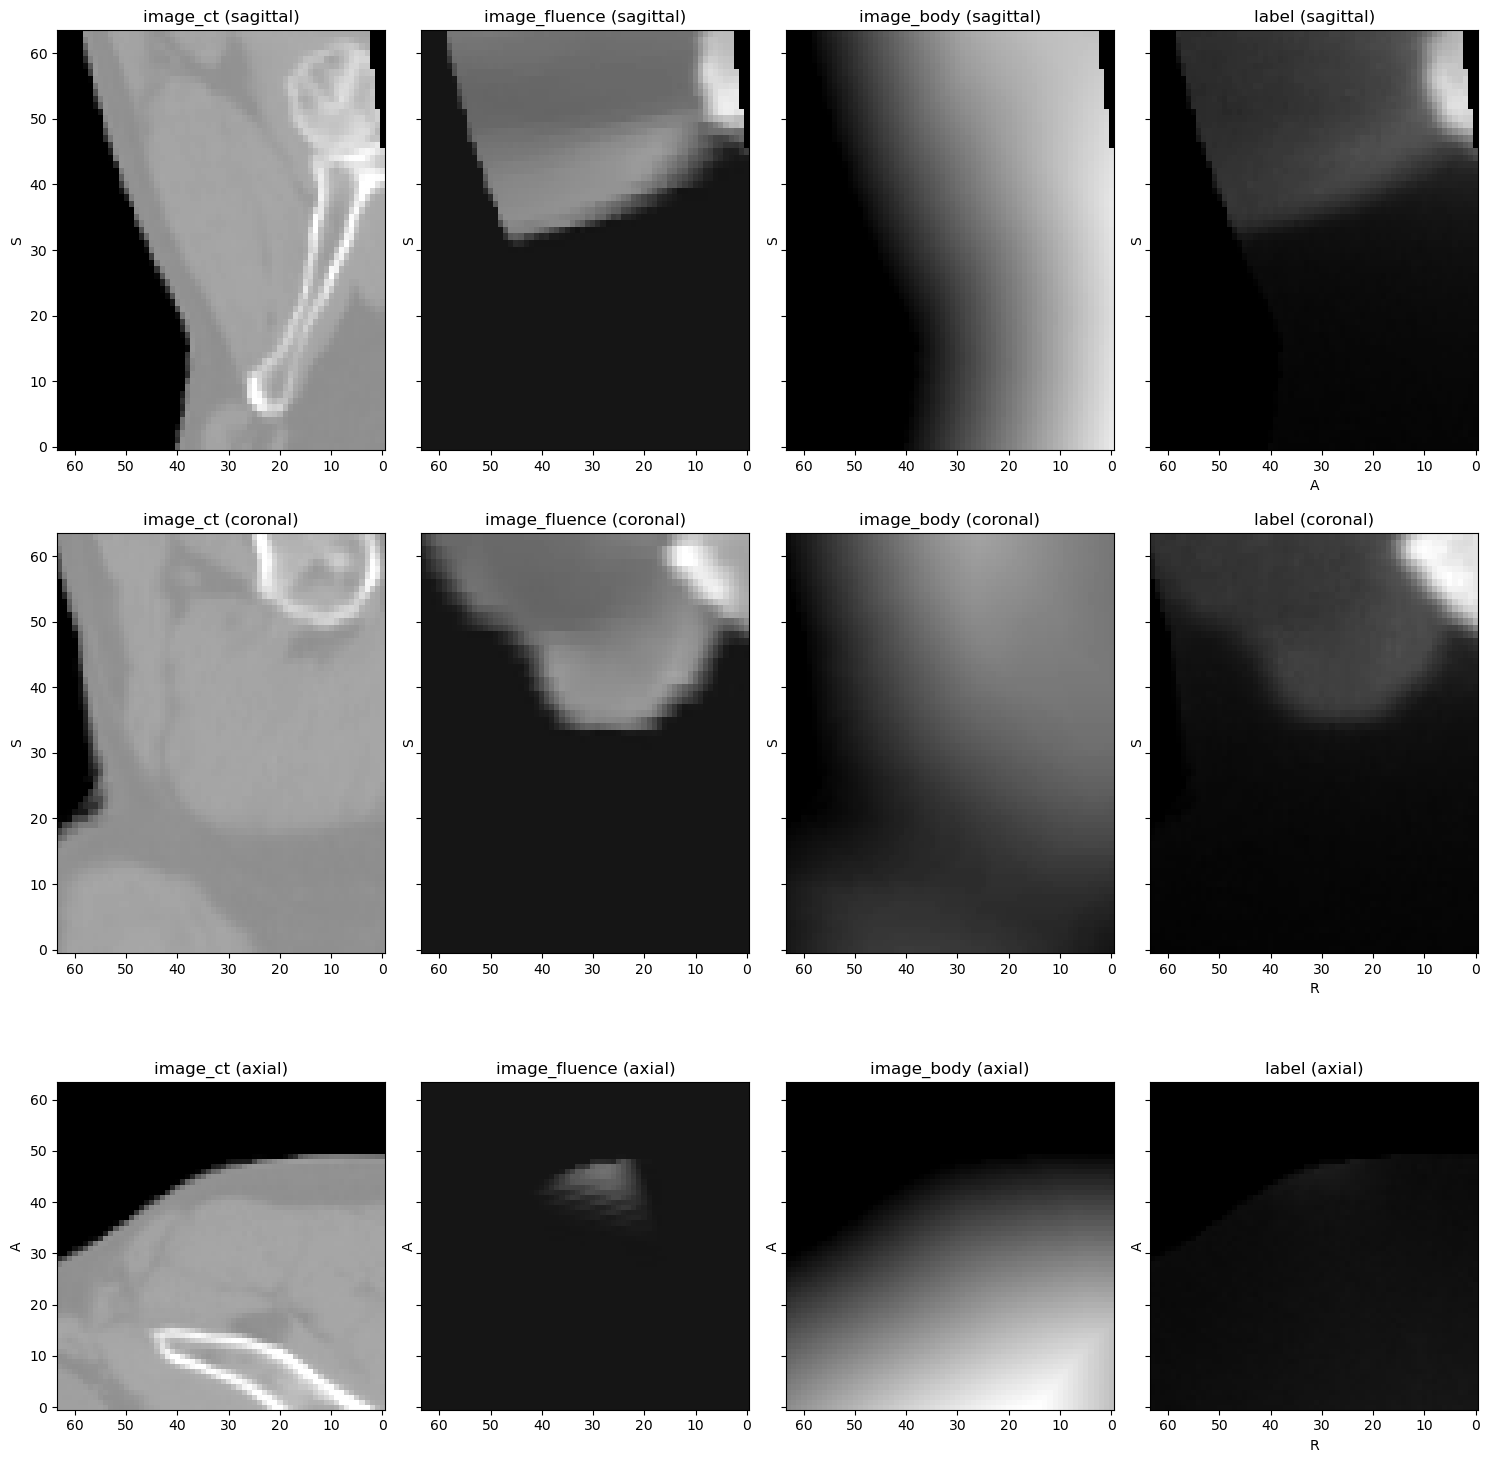

In [93]:
item.plot(figsize=(15,15))